# Data Science Notebook

Build, train and serialize the model

# Import packages

In [1]:
# load data
import matplotlib.pyplot

from submodules.load_data import load_data

# data manipulation
import pandas as pd

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# k-fold cross validation
from sklearn.model_selection import cross_validate

# serializing, compressing, and loading the models
import joblib

# performance
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

# displaying plots
from IPython import display
import matplotlib.image as mpimg
import glob
from skimage.util import montage
import numpy as np

# Load the data

Load semi-colon separated data from disk

In [2]:
# load the data using a python function
#data = load_data()

# without using a python function
csv_path = "../data/raw/dataSepsis.csv"
data = pd.read_csv(csv_path, sep=";")

# Create a Test Dataset
> uses scikit-learn

Performing this early minimizes generalization and bias you may inadvertently apply to your system.
Simply put, a test set of data involves: picking ~20% of the instances randomly and setting them aside.

Some considerations for sampling methods that generate the test set:
1. you don't want your model to see the entire dataset
1. you want to be able to fetch new data for training
1. you want to maintain the same percentage of training data against the entire dataset
1. you want a representative training dataset (~7% septic positive)

https://realpython.com/train-test-split-python-data/

In [3]:
# sets 10%/15%/20% of the data aside for testing, sets the random number generate to it always generates the same shuffled indicies
# x = 2 dimensional array with inputs
# X_train is the training part of the first sequence (x)
# X_test is the test part of the first sequence (x)
# y = 1 dimensional array with outputs
# y_train is the labeled training part of the second sequence
# y_test is the labeled test part of the second sequence
# axis Whether to drop labels from the index (0 or ‘index’) or columns (1 or ‘columns’)
# test_size is the amount of the total dataset to set aside for testing = 10%
# random state fixes the randomization so you get the same results each time
# Shuffle before the data is split, it is shuffled
# stratified splitting keeps the proportion of y values trhough the train and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(data.drop(["Age", "Unit1", "Unit2", "HospAdmTime", "ICULOS", "Gender", "Bilirubin_direct", "TroponinI", "isSepsis"], axis=1),
    data["isSepsis"], test_size=0.20,
    random_state=42, stratify=data["isSepsis"])

# Prepare data for Machine Learning
Instead of preparing data manually, write functions to:
1. reproduce transformations easily on any dataset (e.g., data refresh)
1. builds a library of functions to reuse in future projects
1. use functions in live stream to transform new data before inferencing

## Data cleaning
1. transform current and future null values
1. impute median for missing attributes (>7k)

### Transform missing values from numeric data

In [4]:
# create simpleimputer instance
# replace attributes missing values with median of the attribute
imputer = SimpleImputer(strategy="median")

# fit applies the imputer to ALL numeric data in case new data includes null values
# when system goes live
# results are stored in a imputer.statistics_ value
imputer.fit_transform(X_train)

array([[ 87.  ,  98.5 ,  36.5 , ...,   6.8 , 251.  , 139.  ],
       [ 72.  ,  98.  ,  36.8 , ...,   7.5 , 251.  , 150.  ],
       [ 72.  ,  99.  ,  36.28, ...,   2.6 , 251.  , 183.  ],
       ...,
       [ 72.  ,  95.  ,  36.8 , ...,   6.2 , 251.  , 107.  ],
       [ 78.5 , 100.  ,  36.65, ...,  11.1 , 251.  , 173.  ],
       [ 64.  , 100.  ,  36.22, ...,  10.  , 251.  , 339.  ]])

In [5]:
# apply the trained imputer to transform the training set replacing the
# missing values with learn medians
N = imputer.transform(X_train)
# result above is plain NumPy array with transformed features
# put back to a pandas DataFrame
M = pd.DataFrame(N, columns=X_train.columns, index=X_train.index)
M.head()

HR  O2Sat   Temp    SBP    MAP   DBP  Resp  EtCO2  BaseExcess  HCO3  \
26908  87.0   98.5  36.50  108.0  73.00  63.0  16.5   33.0         0.0  24.0   
5174   72.0   98.0  36.80  145.0  86.33  62.0  17.0   33.0         0.0  25.0   
15997  72.0   99.0  36.28   96.0  70.00  62.0  14.0   33.0         0.0  24.0   
13058  76.5  100.0  35.55  102.0  64.00  49.0  14.0   33.0         0.0  24.0   
23132  68.0   95.0  36.60  119.0  92.00  80.0  20.0   33.0         0.0  24.0   

       ...  Magnesium  Phosphate  Potassium  Bilirubin_total   Hct   Hgb  \
26908  ...        1.8        3.4        4.2              0.8  27.5   8.7   
5174   ...        1.6        3.4        3.9              0.5  29.2   9.6   
15997  ...        2.2        3.1        3.7              0.8  28.8  10.0   
13058  ...        2.0        3.4        5.2              0.8  26.2   8.9   
23132  ...        1.8        3.4        3.4              0.8  43.6  15.3   

        PTT   WBC  Fibrinogen  Platelets  
26908  30.7   6.8       251.0      139.0  
5174   30.7   7.5       251.0      150.0  
15997  30.7   2.6       251.0      183.0  
13058  66.1  36.0       251.0       79.0  
23132  30.7  10.7       251.0      219.0  

[5 rows x 32 columns]

### Feature Scaling
1. ML algorithms don't work well when numeric attributes have very different scales
    (e.g. HR max 184,  pH max 7.67)
1. Scaling target values is not necessary
1. Apply
    1. normalization (MinMaxScaler) bounds the values to a specific range (e.g. 0-1)
    1. standardization (StandardScaler) less affected by outliers does not bound to range

In [6]:
scaler = StandardScaler()

O = scaler.fit_transform(N)
P = pd.DataFrame(O, columns=X_train.columns, index=X_train.index)
P.head()

HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
26908  0.199062  0.374434 -0.527378 -0.641028 -0.551583 -0.028341 -0.318226   
5174  -0.669441  0.192386 -0.019029  0.998721  0.252568 -0.109121 -0.215282   
15997 -0.669441  0.556483 -0.900167 -1.172838 -0.732562 -0.109121 -0.832944   
13058 -0.408890  0.920580 -2.137151 -0.906933 -1.094521 -1.159260 -0.832944   
23132 -0.901042 -0.899906 -0.357928 -0.153535  0.594619  1.344918  0.402379   

          EtCO2  BaseExcess      HCO3  ...  Magnesium  Phosphate  Potassium  \
26908  0.013681     0.03009 -0.042334  ...  -0.607165  -0.107243   0.185125   
5174   0.013681     0.03009  0.308687  ...  -1.216605  -0.107243  -0.318210   
15997  0.013681     0.03009 -0.042334  ...   0.611715  -0.403405  -0.653767   
13058  0.013681     0.03009 -0.042334  ...   0.002275  -0.107243   1.862907   
23132  0.013681     0.03009 -0.042334  ...  -0.607165  -0.107243  -1.157101   

       Bilirubin_total       Hct       Hgb       PTT       WBC  Fibrinogen  \
26908        -0.117318 -0.855207 -1.106481 -0.173873 -0.645006   -0.065903   
5174         -0.289078 -0.540252 -0.625355 -0.173873 -0.537316   -0.065903   
15997        -0.117318 -0.614359 -0.411521 -0.173873 -1.291144   -0.065903   
13058        -0.117318 -1.096055 -0.999564  2.313841  3.847193   -0.065903   
23132        -0.117318  2.127604  2.421778 -0.173873 -0.045021   -0.065903   

       Platelets  
26908  -0.709709  
5174   -0.594803  
15997  -0.250085  
13058  -1.336469  
23132   0.125971  

[5 rows x 32 columns]

### Transformation Pipeline

Common to apply many transformation steps in a specific order (fill the nulls before you apply the scaling)

In [7]:
# this pipeline should work for all the estimators/algorithms
pipeline = Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('std_scaler', StandardScaler()),
                    ])


# this is the transformed data to train from
X_train_prepared = pipeline.fit_transform(X_train)

In [8]:
# neural networks sometimes expect a 0-1 normalized scale and perform better
pipeline_minmax = Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('minMax', MinMaxScaler()),
                    ])
# this is the transformed data to train the MLP from
X_train_prepared_m = pipeline_minmax.fit_transform(X_train)

In [9]:
# compress and save the pipeline
joblib.dump(pipeline, "../data/transform/pipeline.pkl")
joblib.dump(pipeline_minmax, "../data/transform/pipeline_minmax.pkl")

['../data/transform/pipeline_minmax.pkl']

# Model Selection

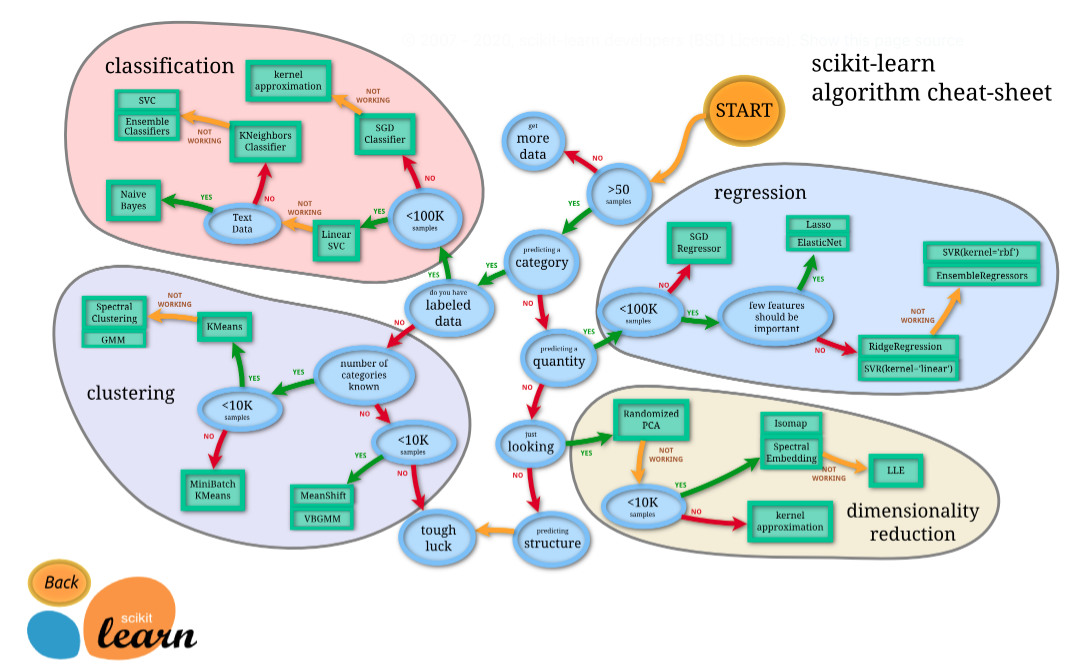

In [10]:
display.Image('../images/scikitlearn-choose-right-estimator.png')

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Classifier Comparison

[Classification Model Comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html?highlight=svm%20svc)

1. [Linear Support Vector Machine "SVM" Support Vector Classifier "SVC"](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
1. [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
1. [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
1. [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
1. [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
1. [Stochastic Gradient Descent "SGD" Classifier](https://scikit-learn.org/stable/modules/sgd.html#classification)
1. [Neural Network Multi-Layer Perceptron Classifier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron)
1. [XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbclassifier#xgboost.XGBClassifier)

## Scoring
1. https://arifromadhan19.medium.com/part-1-regression-and-classification-model-evaluation-bc7f6ab3b4dd
1. https://scikit-learn.org/stable/modules/cross_validation.html#
1. https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

Scoring metrics for Classification models using cross valiation
1. Accuracy - how accurate the predictions are
1. Precision - is the ability of the classifier not to label as positive a sample that is negative
1. Recall - is the ability of the classifier to find all the positive samples
1. F1 Score - harmoic mean (more weight to low values) of precision and recall

Best practice to save every model you experiment with so you can come back easily to any model.
Save both the hyperparameters and trained parameter, as well as the cross-validation scores and predictions.
This will allow you to easily compare scores across model types. Use Pickle or joblib libraries.

## Linear SVM SVC
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [11]:
# select the SVM
clf = svm.SVC()

In [12]:
# fit the model to the data
CLF = clf.fit(X_train_prepared, y_train)

In [13]:
# calculate one or more scores and timings for each CV split
cv_lin_svm = cross_validate(CLF, # estimator to fit
                            X_train_prepared, # data to fit
                            y_train, # target variable isSepsis
                            n_jobs=-1, # use all the processors in parallel
                            cv=3, # splitting strategy to compute the score N consecutive times with different splits
                            scoring="f1", # for binary targets
                            return_train_score=True)

# display the scoring
cv_lin_svm

{'fit_time': array([9.0743041, 9.010221 , 8.904181 ]),
 'score_time': array([6.75510287, 6.72270179, 6.07538009]),
 'test_score': array([0.11155378, 0.10358566, 0.13003901]),
 'train_score': array([0.20886076, 0.25230769, 0.23587834])}

#### Confusion Matrix
A good model will have high values along the diagonal and low values off the diagonal.
You can see where the model is struggling by assessing the highest values not on the diagonal.
- https://deepai.org/machine-learning-glossary-and-terms/confusion-matrix

- https://deepai.org/machine-learning-glossary-and-terms/precision-and-recall
- https://en.wikipedia.org/wiki/Confusion_matrix

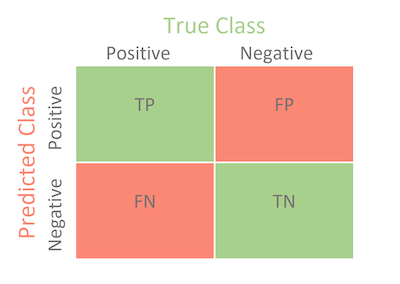

In [14]:
display.Image('../images/confusion_matrix.png')

- True Positives (TP): Positive samples (septic) predicted as positive (septic)
- False Positives (FP): Negative samples (non-septic) predicted as positive (septic)
- False Negatives (FN): Positive samples (septic) predicted as negative (non-septic)
- True Negatives (TN): Negative samples (non-septic) predicted as negative (non-septic)

SVC Confusion Matrix
[[26909    14]
 [ 1824   294]]


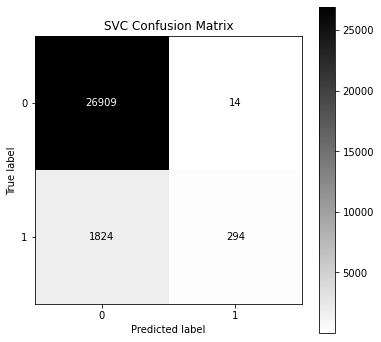

In [15]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

%matplotlib inline

title = "SVC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF,
                             X_train_prepared,
                             y_train,
                             cmap="binary",
                             ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/svc_cm.png", dpi=400)

#### Precision Recall Curve
A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds.

- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

 SVC Precision Recall Curve
0.7034653534387035


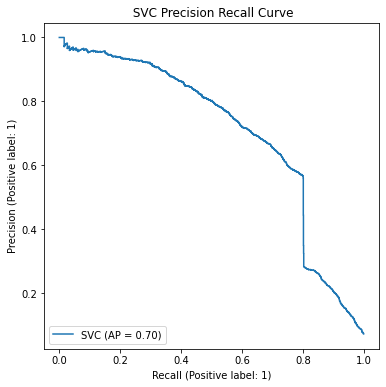

In [16]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = " SVC Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF,
                                   X_train_prepared,
                                   y_train,
                                   pos_label=1,
                                   ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/svc_prc.png", dpi=400)

In [17]:
# save and compress the model

#joblib.dump(svc, "../models/experiment/svc_model.pkl" + ".compressed", compress=True,)
# gzip ~ 577k
#joblib.dump(svc, "../models/experiment/svc_model.pkl" + '.gz', compress=('gzip', 3))
# bzip ~ 444k
joblib.dump(CLF, "../models/experiment/svc_model.pkl", compress=('bz2', 3))
# reference to load the model
#svc_model = joblib.load("../model/experiment/svc_model.pkl")

['../models/experiment/svc_model.pkl']

## Naive Bayes
https://scikit-learn.org/stable/modules/naive_bayes.html

In [18]:
# select the estimator
CLF = GaussianNB()

In [19]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

GaussianNB()

In [20]:
cv_n_bayes = cross_validate(CLF, # estimator to fit
                            X_train_prepared, # data to fit
                            y_train, # target variable isSepsis
                            n_jobs=-1, # use all the processors in parallel
                            verbose=0, # verbosity level
                            cv=3, # splitting strategy to compute the score N consecutive times with different splits
                            scoring="f1", # for binary targets
                            return_train_score=True)

# display the scoring
cv_n_bayes

{'fit_time': array([0.02076411, 0.02407432, 0.02057719]),
 'score_time': array([0.00736809, 0.01000881, 0.00844693]),
 'test_score': array([0.28418231, 0.26155462, 0.29024943]),
 'train_score': array([0.28716306, 0.27140549, 0.28276798])}

#### Confusion Matrix

GNB Confusion Matrix
[[24245  2678]
 [ 1351   767]]


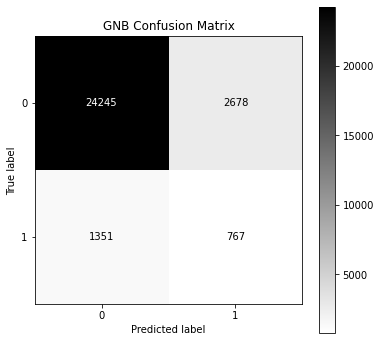

In [21]:
# confusion matrix
title = "GNB Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF,
                             X_train_prepared,
                             y_train,
                             cmap="binary",
                             ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/gnb_cm.png", dpi=400)

#### Precision Recall Curve

GNB Precision Recall Curve
0.18869178977813614


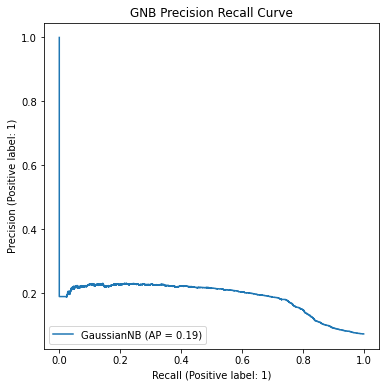

In [22]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "GNB Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF,
                                   X_train_prepared,
                                   y_train,
                                   ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/gnb_prc.png", dpi=400)

In [23]:
# save the model
joblib.dump(CLF, "../models/experiment/gnb_model.pkl", compress=('bz2', 3))
# reference to load the model
#gnb_model = joblib.load("../model/experiment/gnb_model.pkl")

['../models/experiment/gnb_model.pkl']

## K Nearest Neighbor Classification
https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [24]:
# select the estimator
CLF = KNeighborsClassifier()

In [25]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

KNeighborsClassifier()

In [26]:
# cross validate the models performance
cv_knn = cross_validate(CLF,
                        X_train_prepared,
                        y_train,
                        n_jobs=-1,
                        verbose=1,
                        cv=3,
                        scoring="f1",
                        return_train_score=True)
cv_knn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.2s finished


{'fit_time': array([0.01156282, 0.01164484, 0.01287222]),
 'score_time': array([7.59955907, 7.50092125, 7.10195112]),
 'test_score': array([0.38752053, 0.36161097, 0.3867121 ]),
 'train_score': array([0.5047619 , 0.51445835, 0.50887062])}

#### Confusion Matrix

KNN Confusion Matrix
[[26478   445]
 [ 1189   929]]


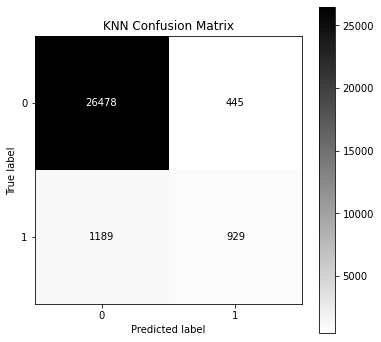

In [27]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "KNN Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/knn_cm.png", dpi=400)

#### Precision Recall Curve

KNN Precision Recall Curve
0.5574472516366924


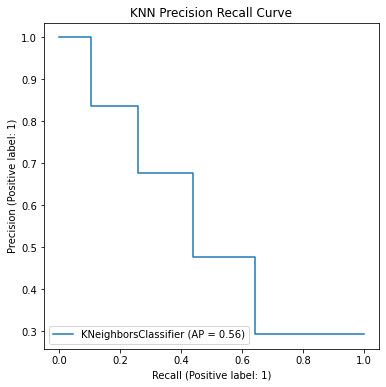

In [28]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "KNN Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/knn_prc.png", dpi=400)

In [29]:
# save the model
joblib.dump(CLF, "../models/experiment/knn_model.pkl", compress=('bz2', 3))
# reference to load the model
#knn_model = joblib.load("../model/experiment/knn_model.pkl")


['../models/experiment/knn_model.pkl']

## Random Forest Classifier

In [30]:
# select the estimator
CLF = RandomForestClassifier()

In [31]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

RandomForestClassifier()

In [32]:
# cross validate the models performance
cv_rfc = cross_validate(CLF,
                       X_train_prepared,
                       y_train,
                       n_jobs=-1,
                       cv=3,
                       scoring="f1",
                       return_train_score=True)
cv_rfc

{'fit_time': array([3.10262513, 3.08248305, 3.11695576]),
 'score_time': array([0.10693598, 0.10801888, 0.10938597]),
 'test_score': array([0.57813911, 0.56222023, 0.55248619]),
 'train_score': array([0.99858357, 0.99929178, 0.99964602])}

#### Confusion Matrix

RFC Confusion Matrix
[[26921     2]
 [    0  2118]]


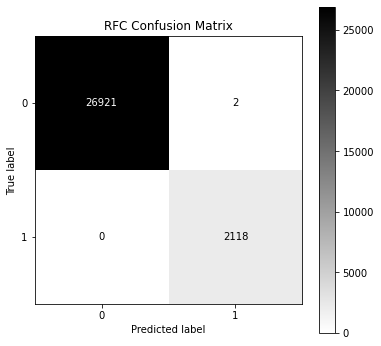

In [33]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "RFC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/rfc_cm.png", dpi=400)

#### Precision Recall Curve

RFC Precision Recall Curve
0.9990703477449326


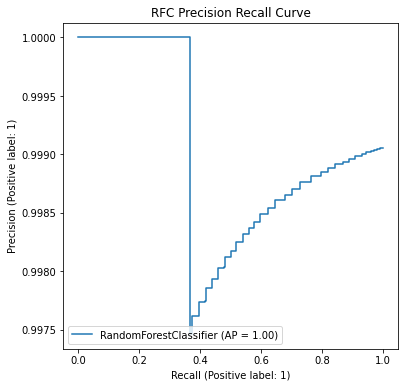

In [34]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "RFC Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/rfc_prc.png", dpi=400)

In [35]:
# save the model
joblib.dump(CLF, "../models/experiment/rfc_model.pkl", compress=('bz2', 3))
# reference to load the model
#rfc_model = joblib.load("../model/experiment/rfc_model.pkl")

['../models/experiment/rfc_model.pkl']

## Logistic Regression
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression)

In [36]:
# select the classifier
CLF = LogisticRegression()

In [37]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

LogisticRegression()

In [38]:
# set a variable to Logistic regression with verbosity
cv_log = cross_validate(CLF,
                            X_train_prepared, # attributes
                            y_train, # labels isSepsis
                            n_jobs=-1, # use all the processors in parallel
                            verbose=1, # verbosity level
                            cv=3, # splitting strategy to compute the score N consecutive times with different splits
                            scoring="f1", # for binary targets
                            return_train_score=True) # computationally expensive, whether to include training scores on parameters impact
cv_log

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


{'fit_time': array([0.04905605, 0.05476594, 0.06125903]),
 'score_time': array([0.00380898, 0.00384402, 0.00455308]),
 'test_score': array([0.03556772, 0.01891892, 0.02770083]),
 'train_score': array([0.02481048, 0.03559206, 0.03417635])}

#### Confusion Matrix

Log Confusion Matrix
[[26886    37]
 [ 2089    29]]


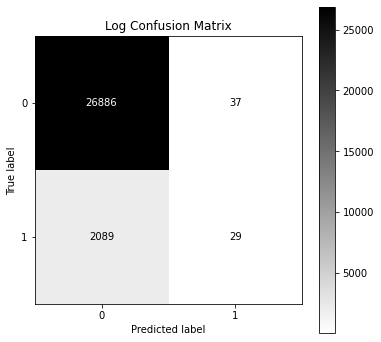

In [39]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "Log Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/log_cm.png", dpi=400)

#### Precision Recall Curve

Log Precision Recall Curve
0.20086565089690556


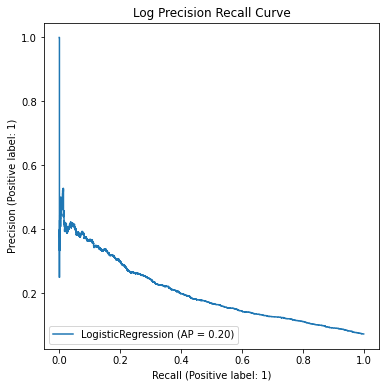

In [40]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "Log Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/log_prc.png", dpi=400)

In [41]:
# save the model
joblib.dump(CLF, "../models/experiment/log_model.pkl", compress=('bz2', 3))
# reference to load the model
#log_model = joblib.load("model/experiment/log_model.pkl")

['../models/experiment/log_model.pkl']

## SGDClassifier

Capable of handling very large datasets efficiently, because SGD deals with training instances independently (well suited for online
learning)

In [42]:
# select the classifier
#CLF = SGDClassifier()
# parameters initially tested
CLF = SGDClassifier(loss="log", penalty="elasticnet", shuffle=True, learning_rate='optimal')

In [43]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

SGDClassifier(loss='log', penalty='elasticnet')

In [44]:
cv_sgd = cross_validate(CLF,
                            X_train_prepared, # attributes
                            y_train, # labels isSepsis
                            n_jobs=-1, # use all the processors in parallel
                            verbose=1, # verbosity level
                            cv=3, # splitting strategy to compute the score N consecutive times with different splits
                            scoring="f1", # for binary targets
                            return_train_score=True) # computationally expensive, whether to include training scores on parameters impact

cv_sgd

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


{'fit_time': array([0.19302607, 0.19836211, 0.11280274]),
 'score_time': array([0.00383162, 0.00386977, 0.003021  ]),
 'test_score': array([0.07692308, 0.0055788 , 0.06374502]),
 'train_score': array([0.07554417, 0.00840336, 0.06649283])}

#### Confusion Matrix

SGD Confusion Matrix
[[26850    73]
 [ 2080    38]]


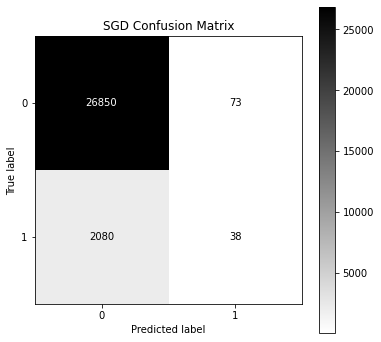

In [45]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "SGD Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/sgd_cm.png", dpi=400)

#### Precision Recall Curve

SGD Precision Recall Curve
0.17620662912701893


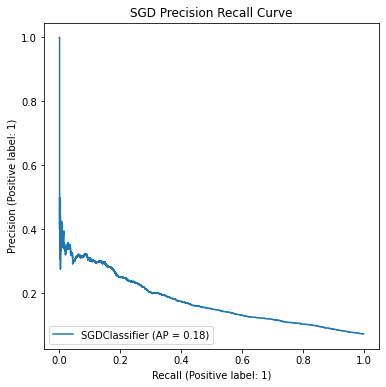

In [46]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "SGD Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/sgd_prc.png", dpi=400)

In [47]:
# serialize the model
joblib.dump(CLF, "../models/experiment/sgd_model.pkl", compress=('bz2', 3))
# reference load the model
#sgd_model = joblib.load("../model/experiment/sgd_model.pkl")

['../models/experiment/sgd_model.pkl']

## MLP Classifier

In [48]:
# select the classifier
CLF = MLPClassifier()
#CLF = MLPClassifier(solver='sgd', activation='relu', max_iter=5000, #hidden_layer_sizes=(50,50,50,50), verbose=0, learning_rate="adaptive")

In [49]:
# fit the model to the data
CLF.fit(X_train_prepared_m, y_train)

/Users/davidmarcus/.virtualenvs/sepsisDetection /lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [50]:
cv_mlp = cross_validate(CLF,
                       X_train_prepared_m,
                       y_train,
                       cv=3,
                       scoring="f1",
                       return_train_score=True,
                       verbose=1)
cv_mlp


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/davidmarcus/.virtualenvs/sepsisDetection /lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidmarcus/.virtualenvs/sepsisDetection /lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidmarcus/.virtualenvs/sepsisDetection /lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.0s finished


{'fit_time': array([16.23736215, 16.52237988, 16.9514339 ]),
 'score_time': array([0.03389382, 0.03400397, 0.03821707]),
 'test_score': array([0.25986079, 0.23826715, 0.18339529]),
 'train_score': array([0.27464789, 0.27267338, 0.19925743])}

#### Confusion Matrix

MLP Confusion Matrix
[[26787   136]
 [ 1627   491]]


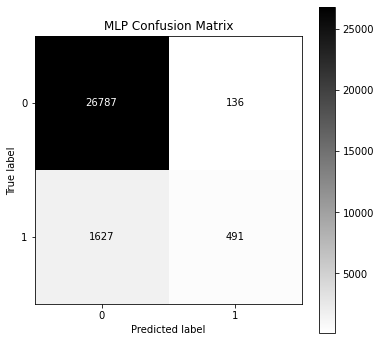

In [51]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "MLP Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared_m, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/mlp_cm.png", dpi=400)

#### Precision Recall Curve

MLP Precision Recall Curve
0.5312807928809868


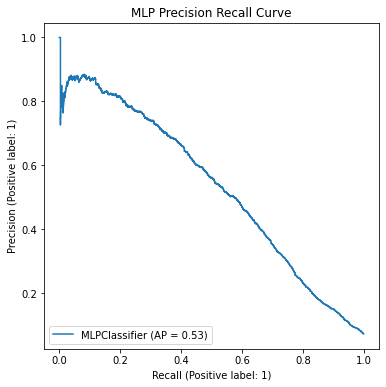

In [52]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "MLP Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared_m, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/mlp_prc.png", dpi=400)

In [53]:
# save the model
joblib.dump(CLF, "../models/experiment/mlp_model.pkl", compress=('bz2', 3))
# reference to load the model
#mlp_model = joblib.load("model/experiment/mlp_model.pkl")

['../models/experiment/mlp_model.pkl']

## XGBoost Classifier

Learning task parameter = https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

In [54]:
# select the estimator
#CLF = XGBClassifier()
CLF = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [55]:
# fit the model to the data
CLF.fit(X_train_prepared, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [56]:
#
cv_xgboost = cross_validate(CLF,
                            X_train_prepared,
                            y_train,
                            cv=3,
                            scoring="f1",
                            return_train_score=True,
                            verbose=0)
cv_xgboost

{'fit_time': array([0.86220503, 0.86967182, 0.85816884]),
 'score_time': array([0.00847697, 0.00909591, 0.00968528]),
 'test_score': array([0.60085106, 0.59416446, 0.57117278]),
 'train_score': array([0.91826215, 0.90915778, 0.91097156])}

#### Confusion Matrix

XGBC Confusion Matrix
[[26794   129]
 [  404  1714]]


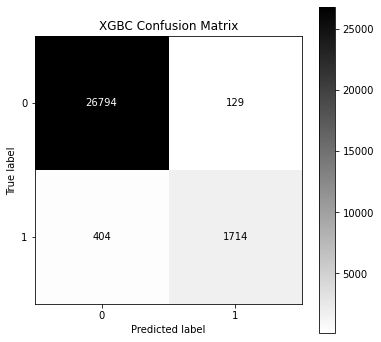

In [57]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "XGBC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(CLF, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/experiment/xgbc_cm.png", dpi=400)

#### Precision Recall Curve

XGBC Precision Recall Curve
0.9501376463799986


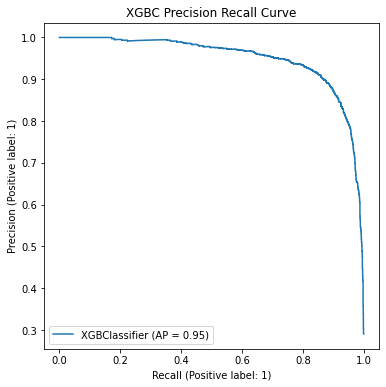

In [58]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "XGBC Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(CLF, X_train_prepared, y_train, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/experiment/xgbc_prc.png", dpi=400)


In [59]:
# save the model
joblib.dump(CLF, "../models/experiment/xgbc_model.pkl", compress=('bz2', 3))

# reference to load the model
#xgbc_model = joblib.load("models/experiment/xgbc_model.pkl")

['../models/experiment/xgbc_model.pkl']

# Model Down-selection

In [60]:
%matplotlib inline

In [61]:
# print all of the stored confusion matrix plots in grid/montage
cms = []
for img_path in glob.glob('../reports/figures/experiment/*_cm.png'):
    cms.append(mpimg.imread(img_path))
plt.figure(figsize=(400,400))
plt.imshow(montage(np.array(cms), multichannel=True))
plt.savefig("../reports/figures/experiment/montage_conf_matricies.png", dpi=400)

In [62]:
# print all of the stored performance recall curve plots in grid/montage
prc = []
for img_path in glob.glob('../reports/figures/experiment/*_prc.png'):
    prc.append(mpimg.imread(img_path))
plt.figure(figsize=(400,400))
plt.imshow(montage(np.array(prc), multichannel=True))
plt.savefig("../reports/figures/experiment/montage_prec_recall_curve.png", dpi=400)

# Launch, Monitor, and Maintain

1. Use joblib to save the train model inclulding full pre-processing and prediction pipeline
1. Load the trained model to production
1. Call the predict() method to make predictions

## Serving
1. Load the model in a web app that will call the predict() method
1. Wrap the model in a dedicated web service that a web app queries with REST API
    1. makes it easy to upgrade without interrupting the primary web app
    1. makes it easy to scale web services and load balance the requests from the web app across the web services
    1. enables the web app to use any language, not just Python

## Monitor
1. Write monitor code the check live performance at regular intervals and trigger alerts when it drops
    1. Could be steep drop if an infrastructure components stops
    1. or, a gentle decay as the world changes resulting in model rot